#**Non-negative matrix factorization using Movielens dataset(subset)**

The following is the link of the article we referred:
 https://towardsdatascience.com/pytorch-implementation-of-matrix-factorization-391bfc003e43

The dataset used here is subset of MovieLens : 
https://www.kaggle.com/rounakbanik/the-movies-dataset.

The dataset consists of a 100,000 ratings from approx 700 users and 9000 movies.

Importing the dependencies..

In [ ]:
import pandas as pd
import torch
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
print("setup complete")

setup complete


Converting the csv ratings file into a pandas dataframe

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/Data/movies_dataset/ratings_small.csv')

In [ ]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings.head()
# ratings.describe()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


Importing movie metadata

In [ ]:
meta = pd.read_csv('/content/drive/MyDrive/Data/movies_dataset/movies_metadata.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
meta = meta[['id', 'original_title', 'original_language', 'genres']]
meta = meta.rename(columns = {'id':'movieId'})
meta = meta[meta['original_language']=='en']

In [ ]:
meta.head()

,movieId,original_title,original_language,genres
0,862,Toy Story,en,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,Grumpier Old Men,en,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,Waiting to Exhale,en,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,Father of the Bride Part II,en,"[{'id': 35, 'name': 'Comedy'}]"


The issue here is that the genre name which we need is inside a dictionary as a value to the 'name' index which is indeed inside a list. Hence we need to extract the value of the key 'name'.

In [ ]:
meta.movieId = pd.to_numeric(meta.movieId, errors = 'coerce')
ratings.movieId = pd.to_numeric(ratings.movieId, errors = 'coerce')

Extracting the genre name from the dictionary in the list

In [ ]:
from ast import literal_eval

In [ ]:
meta['genres'] = meta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
meta.head()

,movieId,original_title,original_language,genres
0,862,Toy Story,en,"[Animation, Comedy, Family]"
1,8844,Jumanji,en,"[Adventure, Fantasy, Family]"
2,15602,Grumpier Old Men,en,"[Romance, Comedy]"
3,31357,Waiting to Exhale,en,"[Comedy, Drama, Romance]"
4,11862,Father of the Bride Part II,en,[Comedy]


In [ ]:
data = pd.merge(ratings, meta, on='movieId', how='inner')
data.head()

,userId,movieId,rating,original_title,original_language,genres
0,1,1371,2.5,Rocky III,en,[Drama]
1,4,1371,4.0,Rocky III,en,[Drama]
2,7,1371,3.0,Rocky III,en,[Drama]
3,19,1371,4.0,Rocky III,en,[Drama]
4,21,1371,3.0,Rocky III,en,[Drama]


In [ ]:
data.tail()

,userId,movieId,rating,original_title,original_language,genres
33276,652,127728,5.0,8:46,en,[Drama]
33277,652,129009,4.0,Love Is a Ball,en,"[Comedy, Romance]"
33278,653,2103,3.0,Solaris,en,"[Drama, Science Fiction, Mystery, Romance]"
33279,659,167,4.0,K-PAX,en,"[Drama, Science Fiction]"
33280,659,563,3.0,Starship Troopers,en,"[Adventure, Action, Thriller, Science Fiction]"


Extracting the first genre in the lists present and if there is no genre we are assigning it an empty string

In [ ]:
row = 0
for i in range(33280):
  row +=1
  if (data['genres'].iloc[i]!=[]):
     data['genres'].iloc[i] = data['genres'].iloc[i][0]
  else:
    data['genres'].iloc[i] = ''

print(row)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


33280


In [ ]:
data['genres'].iloc[33280] = data['genres'].iloc[33280][0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# for i in range(33280):
#   if type(data['genres'].iloc[i])!=str :
#     print(i)

In [ ]:
# x = data['genres'].map(type)!= str

In [ ]:
data.tail()

,userId,movieId,rating,original_title,original_language,genres
33276,652,127728,5.0,8:46,en,Drama
33277,652,129009,4.0,Love Is a Ball,en,Comedy
33278,653,2103,3.0,Solaris,en,Drama
33279,659,167,4.0,K-PAX,en,Drama
33280,659,563,3.0,Starship Troopers,en,Adventure


Checking the data types.

In [ ]:
data.dtypes

userId                 int64
movieId                int64
rating               float64
original_title        object
original_language     object
genres                object
dtype: object

In [ ]:
data['genres'].unique()

array(['Drama', 'Comedy', 'Horror', 'Science Fiction', 'Thriller',
       'Adventure', 'Crime', 'Action', 'Fantasy', 'Romance', 'Animation',
       'Documentary', 'Music', 'War', '', 'Western', 'TV Movie',
       'Mystery', 'History', 'Family', 'Foreign'], dtype=object)

Label encoding if needed

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# data['genres'] = encoder.fit_transform(data['genres'])

X is the matric between user and movies where Xij = 0 if movie hasn't been rated and Xij = rating if it is rated.

In [ ]:
X = data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
X.head(20)

movieId,5,6,11,12,13,14,15,16,17,18,20,21,22,24,25,27,28,35,38,58,59,62,63,65,66,68,69,70,71,73,74,76,77,78,80,82,83,85,87,88,...,105121,105246,105593,107412,107999,109074,109161,110553,111759,111913,112460,112582,112655,112735,112767,114044,114060,115210,115877,116977,118900,120637,121113,122924,127728,128606,129009,130450,130452,130980,132961,133365,134368,134569,134881,140174,142507,148652,158238,160718
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,3.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0


Y is the matrix between genres vs movies where Yij = 0 if the movie isn't having the genre of the row corresponding and Yij = 1 if the movie corresponds to the row/genre. Here the values are filled with userId but later it is changed to boolean.

In [ ]:
Y = data.pivot_table(index='genres', columns='movieId',fill_value=0, values='userId')
Y.head(20)

movieId,5,6,11,12,13,14,15,16,17,18,20,21,22,24,25,27,28,35,38,58,59,62,63,65,66,68,69,70,71,73,74,76,77,78,80,82,83,85,87,88,...,105121,105246,105593,107412,107999,109074,109161,110553,111759,111913,112460,112582,112655,112735,112767,114044,114060,115210,115877,116977,118900,120637,121113,122924,127728,128606,129009,130450,130452,130980,132961,133365,134368,134569,134881,140174,142507,148652,158238,160718
genres,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000,0.000000,0.00,0,0.000000,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,...,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0.000000,0.00,73,0,0.000000,0,0,0.000000,0,0,0,624,0,481,15,0,388,0,0.0,0,0,0,44,0
Action,0.000000,334.096154,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,397,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000,0.000000,0.00,0,0.000000,0.000000,0.0,0,0.0,0.0,281.4,0.000000,0,0.000000,0.000000,...,0,0.0,0.0,298,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0.000000,0.00,0,0,0.000000,0,0,119.333333,0,547,0,0,0,0,0,0,0,0,0.0,355,0,0,0,0
Adventure,0.000000,0.000000,353.378049,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,362.346154,0.000000,0.000000,390.815789,0,0.000000,0.000000,0.000000,0.000000,0,337.711111,0.0,0.00000,0.000000,0.0,0.0,0.000,0.000000,0.00,0,0.000000,381.684211,0.0,0,0.0,0.0,0.0,0.000000,391,562.333333,0.000000,...,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0.000000,0.00,0,0,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
Animation,0.000000,0.000000,0.000000,347.277778,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,342.363636,0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000,0.000000,0.00,0,0.000000,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,...,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0.000000,0.00,0,425,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,378,0.0,0,0,0,0,0
Comedy,0.000000,0.000000,0.000000,0.000000,409.625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0,0.00000,0.000000,0.0,0.0,405.625,0.000000,0.00,0,0.000000,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,...,0,359.5,0.0,0,73,0,0,274.5,0.0,0,0.0,547,0,547,0,0,384.666667,0.00,0,0,549.666667,343,262,0.000000,0,0,652,0,281,0,0,0,0,0,585.5,0,0,0,0,0
Crime,320.785714,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0,0.00000,0.000000,0.0,424.4,0.000,0.000000,0.00,0,0.000000,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,...,0,0.0,0.0,0,0,0,547,0.0,0.0,0,0.0,0,0,0,0,0,0.000000,0.00,0,0,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
Documentary,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,317.157895,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000,0.000000,0.00,0,0.000000,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,...,624,0.0,0.0,0,0,0,0,0.0,0.0,600,0.0,0,0,0,0,0,0.000000,0.00,0,0,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
Drama,0.000000,0.000000,0.000000,0.000000,0.000,332.258065,0.000000,320.511364,0.000000,0.000000,312.076923,0.000000,0.000000,0,348.564356,419.142857,315.388889,0.000000,0,0.000000,524.5,0.00000,0.000000,370.9,0.0,0.000,338.227273,331.75,391,224.615385,0.000000,280.8,0,0.0,405.5,0.0,402.666667,0,0.000000,380.826087,...,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0.0,0,262,0,0,262,0.000000,0.00,0,0,0.000000,0,0,0.000000,652,0,0,0,0,0,0,624,0,0,0.0,0,15,0,0,0
Family,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0

Preparing train and test data.

Here the transpose is used as train_test_spli() does not allow the rows to be different so transpose inverts the matrix and the resultant matrices are transposed again in the following codes.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.transpose(X), np.transpose(Y), test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T


In [ ]:
X_train.shape

torch.Size([671, 1648])

Preparing train_mask.

In [ ]:
mask_train = np.where(X_train < 1, 0, 1) 
mask_train = torch.tensor(mask_train)
mask_train.shape

torch.Size([671, 1648])

In [ ]:
X_train = torch.tensor(X_train)
X_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([671, 1648])

In [ ]:
X_test.shape

torch.Size([671, 413])

Preparing test_mask.

In [ ]:
mask_test = np.where(X_test < 1, 0, 1) 
mask_test = torch.tensor(mask_test)
mask_test.shape

torch.Size([671, 413])

In [ ]:
X_test = torch.tensor(X_test)
X_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([671, 413])

In [ ]:
y_train = torch.tensor(y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
y_train.shape

torch.Size([21, 1648])

In [ ]:
y_test = torch.tensor(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
y_test.shape

torch.Size([21, 413])

Training and testing without alpha hyperparameter.

Learning curve for Task 3


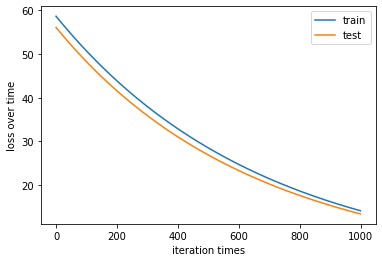

Final train loss on Task 3: 
tensor(14.1291, grad_fn=<AddBackward0>)
Final test loss on Task 3: 
tensor(13.4048, grad_fn=<AddBackward0>)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd

##Define Function and class to be used

prox_plus = nn.Threshold(0,0) ## to make all output postive 

class NMF3(nn.Module):##Model for task 3
    def __init__(self, u, v, t, d):
        super(NMF3, self).__init__()
        self.U = nn.Parameter(torch.rand(u, d, requires_grad=True))
        self.V = nn.Parameter(torch.rand(d, v, requires_grad=True))
        self.T = nn.Parameter(torch.rand(t, d, requires_grad=True))

    def forward(self):
#        return (self.AA>0.5).float()
        res1 = prox_plus(torch.matmul(self.U,self.V))
        res2 = prox_plus(torch.matmul(self.T,self.V))
        return res1,res2



#Set dimension parpemeter and d
u = X_train.shape[0]
v = X_train.shape[1]
t = y_train.shape[0]
d = 30

task3 = NMF3(u,v,t,d)
n_epoch =1000
loss_fn = nn.MSELoss(reduction='mean')

traintask3loss=[]
optimizer = optim.SGD(task3.parameters(), lr=0.001)
for epoch in range(n_epoch):
    X_ , Y_ = task3()
    loss = loss_fn(torch.mul(X_, mask_train), X_train.float()) + loss_fn(Y_, y_train.float())
    task3.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
#    print(loss)
    traintask3loss.append(loss)


u = X_test.shape[0]
v = X_test.shape[1]
t = y_test.shape[0]
d = 30

task3 = NMF3(u,v,t,d)
n_epoch =1000
loss_fn = nn.MSELoss(reduction='mean')

testtask3loss=[]
optimizer = optim.SGD(task3.parameters(), lr=0.001)
for epoch in range(n_epoch):
    X_ , Y_ = task3()
    loss = loss_fn(torch.mul(X_, mask_test), X_test.float()) + loss_fn(Y_, y_test.float())
    task3.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
#    print(loss)
    testtask3loss.append(loss)


print('Learning curve for Task 3')
plt.plot(traintask3loss)
plt.plot(testtask3loss)
plt.ylabel('loss over time')
plt.xlabel('iteration times')
plt.legend(['train','test'])
plt.show()
print('Final train loss on Task 3: ')
print(traintask3loss[-1])
print('Final test loss on Task 3: ')
print(testtask3loss[-1])

With alpha hyperparameter, setting alpha = 0.7 as initially the content matrix should be given more weight.

Learning curve for Task 3


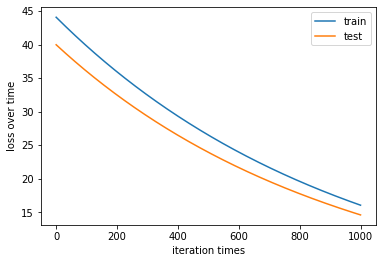

Final train loss on Task 3: 
tensor(16.0667, grad_fn=<AddBackward0>)
Final test loss on Task 3: 
tensor(14.6177, grad_fn=<AddBackward0>)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd

##Define Function and class to be used

prox_plus = nn.Threshold(0,0) ## to make all output postive 

class NMF3(nn.Module):##Model for task 3
    def __init__(self, u, v, t, d):
        super(NMF3, self).__init__()
        self.U = nn.Parameter(torch.rand(u, d, requires_grad=True))
        self.V = nn.Parameter(torch.rand(d, v, requires_grad=True))
        self.T = nn.Parameter(torch.rand(t, d, requires_grad=True))

    def forward(self):
#        return (self.AA>0.5).float()
        res1 = prox_plus(torch.matmul(self.U,self.V))
        res2 = prox_plus(torch.matmul(self.T,self.V))
        return res1,res2


alpha = 0.7
#Set dimension parpemeter and d
u = X_train.shape[0]
v = X_train.shape[1]
t = y_train.shape[0]
d = 30

task3 = NMF3(u,v,t,d)
n_epoch =1000
loss_fn = nn.MSELoss(reduction='mean')

traintask3loss=[]
optimizer = optim.SGD(task3.parameters(), lr=0.001)
for epoch in range(n_epoch):
    X_ , Y_ = task3()
    loss = (1-alpha)*loss_fn(torch.mul(X_, mask_train), X_train.float()) + alpha*loss_fn(Y_, y_train.float())
    task3.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
#    print(loss)
    traintask3loss.append(loss)


u = X_test.shape[0]
v = X_test.shape[1]
t = y_test.shape[0]
d = 30

task3 = NMF3(u,v,t,d)
n_epoch =1000
loss_fn = nn.MSELoss(reduction='mean')

testtask3loss=[]
optimizer = optim.SGD(task3.parameters(), lr=0.001)
for epoch in range(n_epoch):
    X_ , Y_ = task3()
    loss = (1-alpha)*loss_fn(torch.mul(X_, mask_test), X_test.float()) + alpha*loss_fn(Y_, y_test.float())
    task3.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
#    print(loss)
    testtask3loss.append(loss)


print('Learning curve for Task 3')
plt.plot(traintask3loss)
plt.plot(testtask3loss)
plt.ylabel('loss over time')
plt.xlabel('iteration times')
plt.legend(['train','test'])
plt.show()
print('Final train loss on Task 3: ')
print(traintask3loss[-1])
print('Final test loss on Task 3: ')
print(testtask3loss[-1])

With mean absolute error.

Learning curve for Task 3


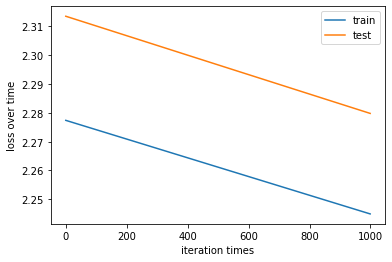

Final train loss on Task 3: 
tensor(2.2449, grad_fn=<AddBackward0>)
Final test loss on Task 3: 
tensor(2.2798, grad_fn=<AddBackward0>)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd

##Define Function and class to be used

prox_plus = nn.Threshold(0,0) ## to make all output postive 

class NMF3(nn.Module):##Model for task 3
    def __init__(self, u, v, t, d):
        super(NMF3, self).__init__()
        self.U = nn.Parameter(torch.rand(u, d, requires_grad=True))
        self.V = nn.Parameter(torch.rand(d, v, requires_grad=True))
        self.T = nn.Parameter(torch.rand(t, d, requires_grad=True))

    def forward(self):
#        return (self.AA>0.5).float()
        res1 = prox_plus(torch.matmul(self.U,self.V))
        res2 = prox_plus(torch.matmul(self.T,self.V))
        return res1,res2


alpha = 0.7
#Set dimension parpemeter and d
u = X_train.shape[0]
v = X_train.shape[1]
t = y_train.shape[0]
d = 30

task3 = NMF3(u,v,t,d)
n_epoch =1000
loss_fn = nn.L1Loss(reduction='mean')

traintask3loss=[]
optimizer = optim.SGD(task3.parameters(), lr=0.001)
for epoch in range(n_epoch):
    X_ , Y_ = task3()
    loss = alpha*loss_fn(torch.mul(X_, mask_train), X_train.float()) + (1-alpha)*loss_fn(Y_, y_train.float())
    task3.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
#    print(loss)
    traintask3loss.append(loss)


u = X_test.shape[0]
v = X_test.shape[1]
t = y_test.shape[0]
d = 30

task3 = NMF3(u,v,t,d)
n_epoch =1000
loss_fn = nn.L1Loss(reduction='mean')

testtask3loss=[]
optimizer = optim.SGD(task3.parameters(), lr=0.001)
for epoch in range(n_epoch):
    X_ , Y_ = task3()
    loss = alpha*loss_fn(torch.mul(X_, mask_test), X_test.float()) + (1-alpha)*loss_fn(Y_, y_test.float())
    task3.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
#    print(loss)
    testtask3loss.append(loss)


print('Learning curve for Task 3')
plt.plot(traintask3loss)
plt.plot(testtask3loss)
plt.ylabel('loss over time')
plt.xlabel('iteration times')
plt.legend(['train','test'])
plt.show()
print('Final train loss on Task 3: ')
print(traintask3loss[-1])
print('Final test loss on Task 3: ')
print(testtask3loss[-1])

Rough work

In [ ]:
U_ = torch.rand(u, d, requires_grad=True)
V_ = torch.rand(d, v, requires_grad=True)

In [ ]:
 res1 = prox_plus(torch.matmul(U_,V_))

In [ ]:
res1

tensor([[6.4773, 6.0863, 6.4303,  ..., 6.2542, 6.5000, 7.4837],
        [7.5069, 7.4613, 8.2099,  ..., 6.8950, 7.9789, 8.2351],
        [6.9464, 6.4126, 6.8499,  ..., 6.9387, 6.6671, 7.7040],
        ...,
        [7.3732, 7.0251, 6.2408,  ..., 6.2832, 6.8723, 7.9767],
        [7.6150, 7.2522, 6.3459,  ..., 6.8912, 6.2710, 6.5913],
        [5.3894, 4.8190, 5.1899,  ..., 4.4695, 5.1026, 5.7726]],
       grad_fn=<ThresholdBackward0>)

In [ ]:
torch.mul(res1,   torch.tensor(mask))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)